## I found that optimization in the time domain worked better than trying to fix things in the frequency domain. 

## I've also tried to phase correct by just doing a cross-correlation in the time domain which works quite well. There is a slight added benefit from doing the phase offset correction as well.

## Here are all the top level function definitions:

In [1]:
import numpy as np
from scipy.signal import windows as wd
import os
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.optimize as so


try:
    import mkl_fft
except:
    mkl_fft = np.fft


def fft(x, axis=None):
    """
    calculates the 1D fft of the numpy array x
    if x is not 1D you need to specify the axis
    """

    if axis is None:
        return np.fft.fftshift(mkl_fft.fft(np.fft.ifftshift(x)))
    else:
        return np.fft.fftshift(mkl_fft.fft(np.fft.ifftshift(x, axes=axis), axis=axis), axes=axis)


def ifft(x, axis=None):
    """
    calculates the 1D ifft of the numpy array x
    if x is not 1D you need to specify the axis
    """

    if axis is None:
        return np.fft.fftshift(mkl_fft.ifft(np.fft.ifftshift(x)))
    else:
        return np.fft.fftshift(mkl_fft.ifft(np.fft.ifftshift(x, axes=axis), axis=axis), axes=axis)


def normalize(vec):
    return vec / np.max(abs(vec))


def rad_to_deg(rad):
    return rad * 180 / np.pi


def deg_to_rad(deg):
    return deg * np.pi / 180


def Number_of_files(path):
    names = [i.name for i in os.scandir(path)]
    return len(names)


def shift_2d(data, shifts):
    ft = mkl_fft.fft(np.fft.ifftshift(data, axes=1), axis=1)  # fftshifted
    freq = np.fft.fftfreq(len(ft[0]))
    phase = np.zeros(data.shape).astype(np.complex128)
    phase[:] = 1j * 2 * np.pi * freq
    phase = (phase.T * shifts).T
    phase = np.exp(phase)
    ft *= phase
    ft = np.fft.fftshift(mkl_fft.ifft(ft, axis=1), axes=1)
    phase_corr = ft.real
    return phase_corr


def t0_correct_via_cross_corr(data, N_zoom=50, plot=True):
    """
    :param data: data as a 2D array
    :param ppifg: points per interferogram
    :param N_zoom: number of data points in the zoomed in window from calculating the phase correction
    :param plot: plot the phase correction (diagnostics)

    :return: phase corrected data as a 2D array
    """
    center = len(data[0]) // 2

    # zoomed in data
    zoom = data[:, center - (N_zoom + 0): center + (N_zoom + 1)].astype(float)
    zoom = (zoom.T - np.mean(zoom, 1)).T

    # appodize to remove f0, use a window of size 50
    window = wd.blackman(N_zoom)
    left = (len(zoom[0]) - N_zoom) // 2
    right = len(zoom[0]) - N_zoom - left
    window = np.pad(window, (left, right), constant_values=0)

    WINDOWS = np.zeros(zoom.shape)
    for n, i in enumerate(zoom):
        ind = np.argmax(abs(i) ** 2)
        roll = ind - len(zoom[0]) // 2
        WINDOWS[n] = np.roll(window, roll)

    zoom_appod = zoom * WINDOWS

    # calculate the shifts
    fft_zoom = fft(zoom_appod, 1)
    ref = fft_zoom[0]
    fft_zoom *= np.conj(ref)
    fft_zoom = np.pad(fft_zoom, ([0, 0], [2 ** 10, 2 ** 10]), constant_values=0.0)
    fft_zoom = ifft(fft_zoom, 1)
    ind = np.argmax(fft_zoom, axis=1) - len(fft_zoom[0]) // 2
    shift = ind * len(zoom[0]) / len(fft_zoom[0])

    # shift correct data
    phase_corr = shift_2d(data, shift)

    if plot:
        # a view of the appodization method for removal of f0
        fig, ax = plt.subplots(1, 2, figsize=np.array([11.9, 4.8]))
        ax[0].plot(normalize(zoom[0]))
        ax[0].plot(WINDOWS[0])
        ax[1].plot(normalize(zoom_appod[0]))

        # check the phase correction
        fig, ax = plt.subplots(1, 2, figsize=np.array([11.9, 4.8]))
        [ax[1].plot(i[center - 100:center + 100]) for i in phase_corr[:50]]
        [ax[1].plot(i[center - 100:center + 100]) for i in phase_corr[-50:]]
        [ax[0].plot(i[center - 100:center + 100]) for i in data[:50]]
        [ax[0].plot(i[center - 100:center + 100]) for i in data[-50:]]
        ax[0].set_title("un corrected")
        ax[1].set_title("corrected")

    return phase_corr, shift


In [2]:
"""" optimiztion in the time domain doesn't work! It never gives an answer different from the initial guess,
even when it's obviously at an unstable maximum. """

zoom = 1500


# shift a signal in time, I've vetted that this gives expected results
def shift(x, dt):
    ft = np.fft.fft(np.fft.ifftshift(x))
    freq = np.fft.fftfreq(len(ft))
    phase = np.exp(1j * 2 * np.pi * freq * dt)
    ft *= phase
    return np.fft.fftshift(np.fft.ifft(ft)).real


# apply a phase offset, I've also vetted that this cycles the ceo phase by the expected amount
def apply_phi0_shift(x, offst):
    hbt = ss.hilbert(x)
    hbt *= np.exp(1j * offst)
    return hbt.real


# function to minimize, I've vetted that this at least looks physical
def error_dt_offst(X, x, x0):
    dt, phi0 = X

    y = shift(x, dt)  # shift x by dt
    y = apply_phi0_shift(y, phi0)  # now apply phase offset to the shifted interferogram
    return np.mean((x0[center - zoom // 2: center + zoom // 2] -
                    y[center - zoom // 2: center + zoom // 2]) ** 2)


# same as func but only with phase offset
# I've vetted that this at least looks physical
def error_offst(X, x, x0):
    phi0 = X

    y = apply_phi0_shift(x, phi0)  # apply phase offset to x
    return np.mean((x0[center - zoom // 2: center + zoom // 2] -
                    y[center - zoom // 2: center + zoom // 2]) ** 2)


class Optimize:
    def __init__(self, data):
        self.data = data

    def error_shift_offst(self, X, n):
        return error_dt_offst(X, self.data[n], self.data[0])

    def error_offst(self, X, n):
        return error_offst(X, self.data[n], self.data[0])


## Load the data, edit the path below to the Data.txt and t_axis.txt files

In [3]:
path = r"../data/Dans_interferograms/"
data = np.genfromtxt(path + "Data.txt")
T = np.genfromtxt(path + "t_axis.txt")
N = np.arange(-len(data[0]) // 2, len(data[0]) // 2)
ppifg = len(N)
center = ppifg // 2

data = (data.T / np.max(data, axis=1)).T
data = (data.T - np.mean(data, axis=1)).T


## Here are the cross-correlation results:

In [4]:
corr, delta_t = t0_correct_via_cross_corr(data, zoom, False)

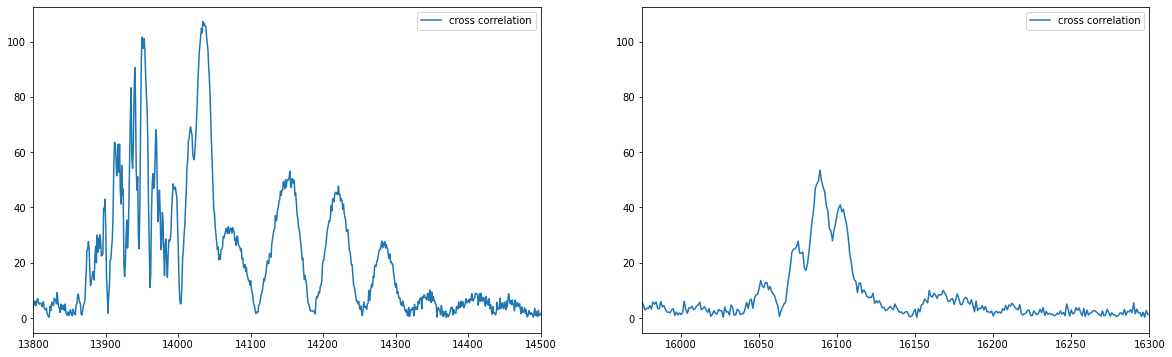

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(abs(fft(np.mean(corr, axis=0))), label="cross correlation")
ax[0].set_xlim(13800, 14500)
ax[0].legend(loc='best')

ax[1].plot(abs(fft(np.mean(corr, axis=0))), label="cross correlation")
ax[1].set_xlim(15975, 16300)
ax[1].legend(loc='best')

## which already works quite well

## Alternatively, we can apply both a linear phase and cycle the $\phi_{\text{ceo}}$ of the interferograms. We had trouble fitting the phase in the frequency domain, so another idea is to do an optimization method by minimizing the error in the time domain:

In [6]:
optimize = Optimize(data)
offst_with_dt_guess = np.zeros((len(data), 2))
CORR = data.copy()
ERROR = np.zeros((len(data)))
for n, i in enumerate(data):
    # dt, phi0 = X
    res = so.minimize(fun=optimize.error_shift_offst,
                      # x0 = np.array([delta_t[n], 0]),
                      x0=np.array([0, 0]),
                      args=(n,),
                      method='Nelder-Mead')
    offst_with_dt_guess[n] = res.x
    ERROR[n] = res.fun

    x = shift(CORR[n], res.x[0])
    x = apply_phi0_shift(x, res.x[1])
    CORR[n] = x


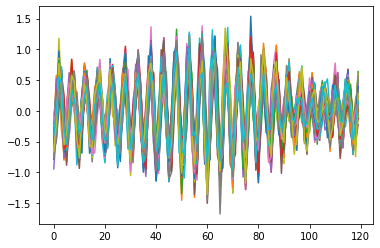

In [7]:
plt.figure()
for i in CORR:
    plt.plot(i[center - 20:center + 100])

## Qualitatively this looks very similar to the cross-correlation. I noted that it's actually applying pretty diferent time shifts compared to the cross-correlation (it uses the phase offset to compensate for the discrepancy in time shifts). 

## Although it qualitatively looks very similar to the cross-correlation in the time domain, it does show an improvement in one of the spectral bands when looking at the spectrum in the frequency domain. 

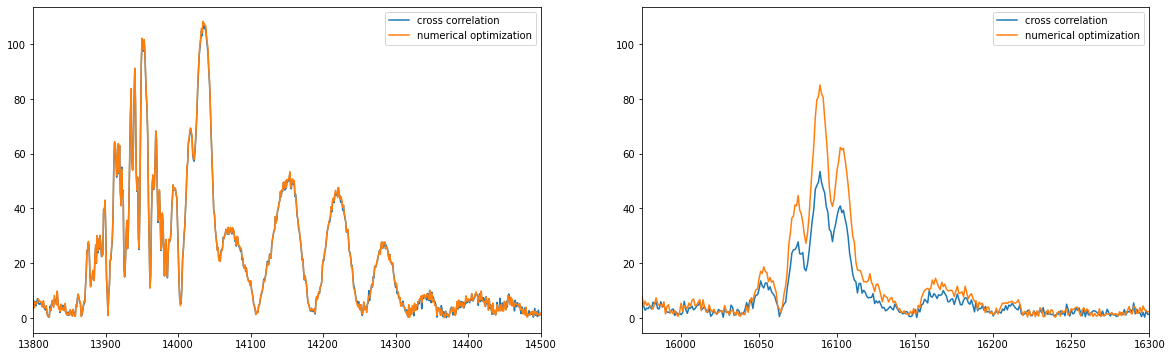

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(abs(fft(np.mean(corr, axis=0))), label="cross correlation")
ax[0].plot(abs(fft(np.mean(CORR, axis=0))), label="numerical optimization")
ax[0].set_xlim(13800, 14500)
ax[0].legend(loc='best')

ax[1].plot(abs(fft(np.mean(corr, axis=0))), label="cross correlation")
ax[1].plot(abs(fft(np.mean(CORR, axis=0))), label="numerical optimization")
ax[1].set_xlim(15975, 16300)
ax[1].legend(loc='best')


## The optimization method is taking an initial guess of $\Delta T = 0$ and $\phi_{\text{ceo}} = 0$. We might be able to improve the results slightly if we take as an initial guess the results that we got from the cross-corelation. Namely, this would be $\Delta T_{\text{cross corr}}$ and $\phi_{\text{ceo}} = 0$.

In [9]:
optimize = Optimize(data)
offst_with_dt_guess = np.zeros((len(data), 2))
CORR = data.copy()
ERROR = np.zeros((len(data)))
for n, i in enumerate(data):
    # dt, phi0 = X
    res = so.minimize(fun=optimize.error_shift_offst,
                      x0 = np.array([delta_t[n], 0]),
#                       x0=np.array([0, 0]),
                      args=(n,),
                      method='Nelder-Mead')
    offst_with_dt_guess[n] = res.x
    ERROR[n] = res.fun

    x = shift(CORR[n], res.x[0])
    x = apply_phi0_shift(x, res.x[1])
    CORR[n] = x


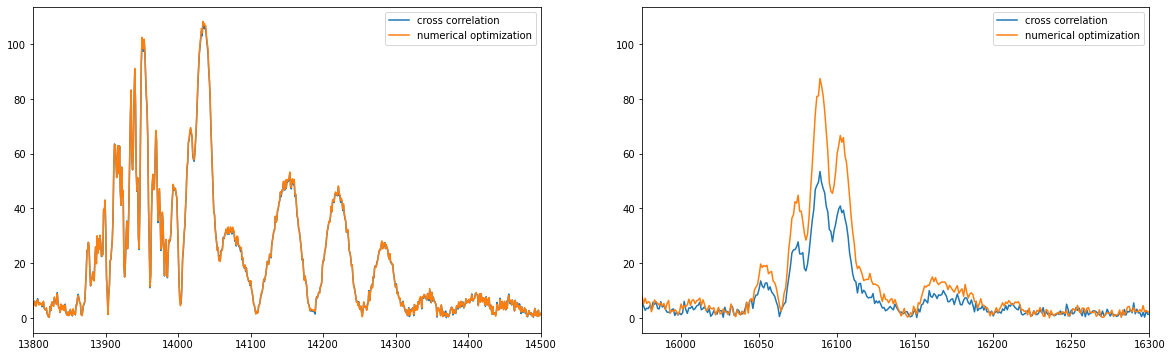

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(abs(fft(np.mean(corr, axis=0))), label="cross correlation")
ax[0].plot(abs(fft(np.mean(CORR, axis=0))), label="numerical optimization")
ax[0].set_xlim(13800, 14500)
ax[0].legend(loc='best')

ax[1].plot(abs(fft(np.mean(corr, axis=0))), label="cross correlation")
ax[1].plot(abs(fft(np.mean(CORR, axis=0))), label="numerical optimization")
ax[1].set_xlim(15975, 16300)
ax[1].legend(loc='best')

## Taking the initial guess for $\Delta T$ from the cross-correlation seems to give basically the same overall performance for pretty different $\Delta T$ and $\phi_{\text{ceo}}$